 # Introduction to Computer Vision - Fall 2025

# Assignment 1

## Detecting and Counting Coins

**Goal:** Build an image-processing pipeline that **segments coins** and **estimates how many coins** are present **without using contours or connected components**.  
Students are asked to use the techniques covered in the Labs 1, 2, and 3

**What you will practice:**
- Point operations
- Neighborhood operations
- Histograms
- Thresholding
- Morphological operations

## Lane Edges Detection
**Goal:** Build an edge detection algorithm to detect the lanes and then apply a mask to select the region of interest (ROI), specifically the road itself.
Students are asked to use the techniques covered in the Labs 1, 2, and 3

**What you will practice:**
- noise cancellation
- cany edge detector

**Constraint:** Do **not** use `findContours`, `connectedComponents`,`cv2.Canny`, or similar labeling functions.  

Code should be well documented (explain your logic)

Plagiarism in code -> 0

AI generated code -> 0

Late submission 5% per day

Submit your completed Colab notebook.


##Detecting and Counting Coins

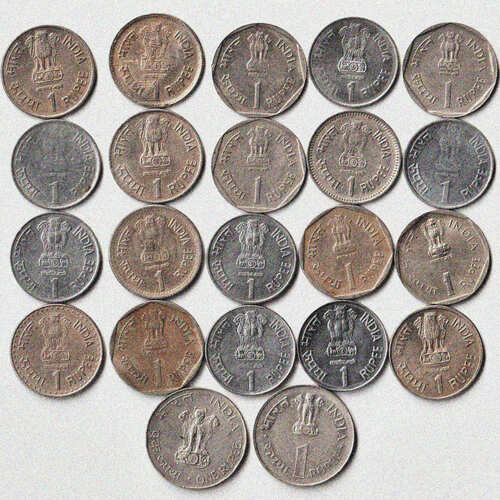

In [9]:
# Download the image
!wget -O coins.jpg "https://drive.google.com/uc?export=download&id=1CwHqnRK1ZiTTfc4B9ofZD4HJPbqfrnQ1"

--2025-09-18 09:26:11--  https://drive.google.com/uc?export=download&id=1CwHqnRK1ZiTTfc4B9ofZD4HJPbqfrnQ1
Resolving drive.google.com (drive.google.com)... 142.251.8.139, 142.251.8.101, 142.251.8.138, ...
Connecting to drive.google.com (drive.google.com)|142.251.8.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1CwHqnRK1ZiTTfc4B9ofZD4HJPbqfrnQ1&export=download [following]
--2025-09-18 09:26:11--  https://drive.usercontent.google.com/download?id=1CwHqnRK1ZiTTfc4B9ofZD4HJPbqfrnQ1&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.170.132, 2404:6800:4008:c19::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.170.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4104743 (3.9M) [image/jpeg]
Saving to: ‘coins.jpg’

coins.jpg           100%[===================>]   3.91M  --.-KB/s    in 0.1s    

2025

In [10]:
# Helper function

import numpy as np
import cv2
import matplotlib.pyplot as plt



def show(title, img):
		plt.figure(figsize=(5,5))
		if img.ndim == 2:
				plt.imshow(img, cmap='gray')
		else:
				plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
		plt.title(title)
		plt.axis('off')
		plt.show()




Explain your logic here

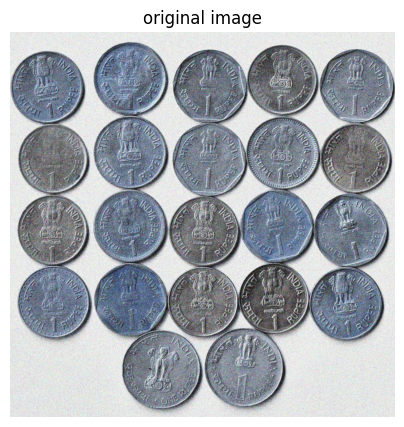

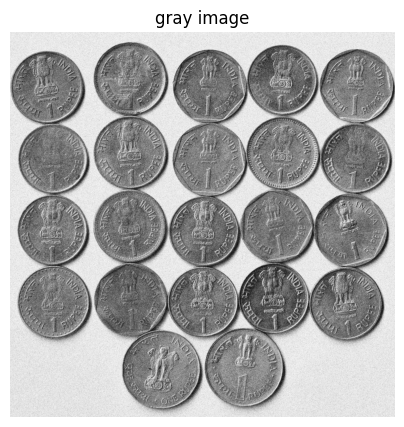

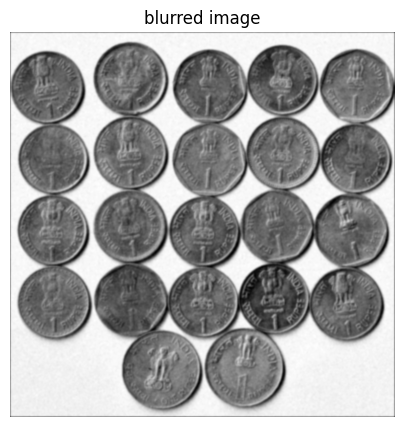

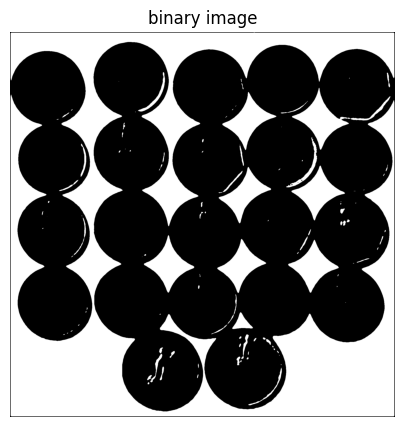

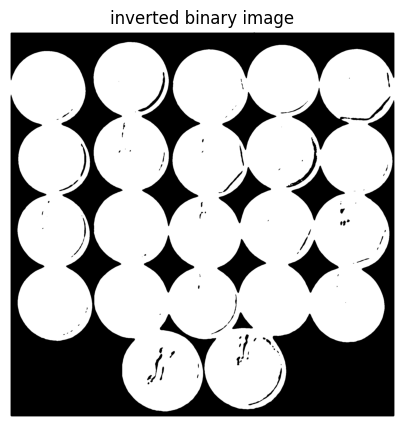

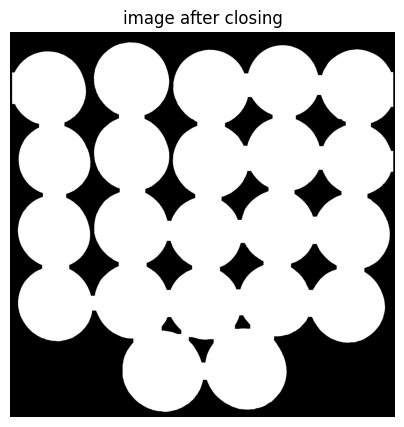

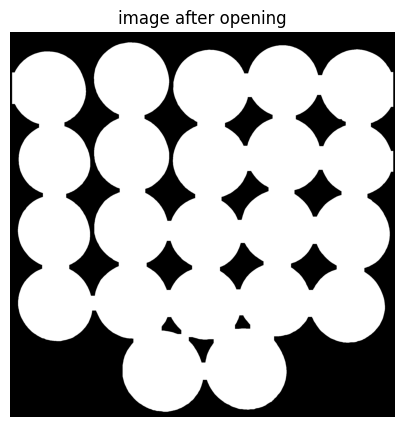

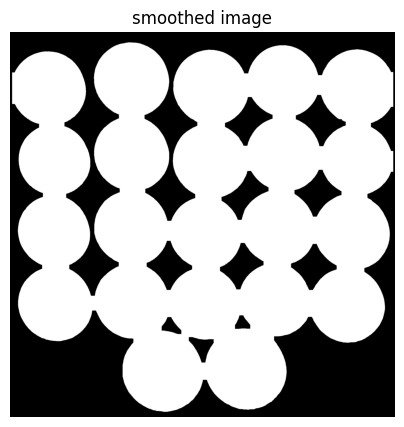

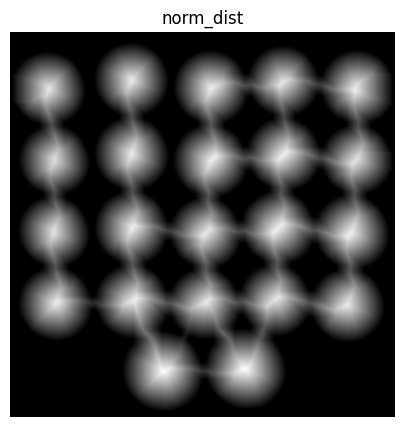

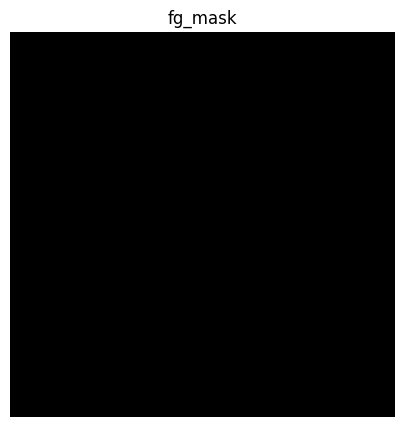

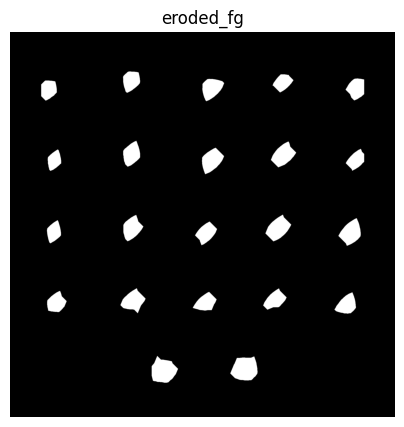

Coins found: 22


In [11]:
from PIL import Image

def load_image(file_path):
    return np.array(Image.open(file_path))

def rgb_to_gray(img):
    if len(img.shape) == 3:
        return np.dot(img[..., :3], [0.114, 0.587, 0.299]).astype(np.uint8)
    return img

# reduces noise and details
def make_gaussian_kernel(size, sigma):
    ax = np.arange(-size // 2 + 1, size // 2 + 1)
    x, y = np.meshgrid(ax, ax)
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))  # 2D Gaussian distribution
    return kernel / kernel.sum()  # Normalize to sum=1

# for image filtering
def apply_convolution(img, kernel):
    h, w = img.shape
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2

    padded = np.pad(img, ((pad_h, pad_h), (pad_w, pad_w)), 'constant')  # Add padding for border handling
    result = np.zeros_like(img, dtype=np.float32)

    # Slide kernel over image and compute sum of products
    for i in range(h):
        for j in range(w):
            region = padded[i:i+k_h, j:j+k_w]
            result[i, j] = np.sum(region * kernel)  # Element-wise multiplication and sum

    return result.astype(np.uint8)

# to reduce noise and detail
def blur_image(img, kernel_size):
    sigma = 0.3 * ((kernel_size - 1) * 0.5 - 1) + 0.8
    kernel = make_gaussian_kernel(kernel_size, sigma)
    return apply_convolution(img, kernel)

def calculate_otsu_threshold(img):
    hist = np.histogram(img.flatten(), 256, [0, 256])[0]
    prob = hist / hist.sum()
    best_thresh = 0
    max_var = 0
    for t in range(1, 256):
        w0, w1 = prob[:t].sum(), prob[t:].sum()
        if w0 == 0 or w1 == 0:
            continue
        mu0 = np.sum(np.arange(t) * prob[:t]) / w0
        mu1 = np.sum(np.arange(t, 256) * prob[t:]) / w1
        var = w0 * w1 * (mu0 - mu1) ** 2
        if var > max_var:
            max_var = var
            best_thresh = t
    binary = np.zeros_like(img)
    binary[img > best_thresh] = 255
    return best_thresh, binary

def morph_operation(img, kernel, operation, iters=1):
    result = img.copy()
    h, w = result.shape
    k_h, k_w = kernel.shape
    pad_h, pad_w = k_h // 2, k_w // 2

    kernel_indices = np.where(kernel == 1)  # Get structuring element coordinates

    for _ in range(iters):
        padded = np.pad(result, ((pad_h, pad_h), (pad_w, pad_w)), 'constant')
        if operation == 'dilate':
            # Expand white regions to fill gaps and holes
            views = [padded[i:i+h, j:j+w] for i, j in zip(*kernel_indices)]
            result = np.max(views, axis=0)
        elif operation == 'erode':
            # Shrink white regions to remove small objects
            views = [padded[i:i+h, j:j+w] for i, j in zip(*kernel_indices)]
            result = np.min(views, axis=0)
        elif operation == 'close':
            # Dilate then erode to fill holes while maintaining size
            views_dilate = [padded[i:i+h, j:j+w] for i, j in zip(*kernel_indices)]
            dilated = np.max(views_dilate, axis=0)
            padded_dilated = np.pad(dilated, ((pad_h, pad_h), (pad_w, pad_w)), 'constant')
            views_erode = [padded_dilated[i:i+h, j:j+w] for i, j in zip(*kernel_indices)]
            result = np.min(views_erode, axis=0)
        elif operation == 'open':
            # Erode then dilate to remove noise while maintaining size
            views_erode = [padded[i:i+h, j:j+w] for i, j in zip(*kernel_indices)]
            eroded = np.min(views_erode, axis=0)
            padded_eroded = np.pad(eroded, ((pad_h, pad_h), (pad_w, pad_w)), 'constant')
            views_dilate = [padded_eroded[i:i+h, j:j+w] for i, j in zip(*kernel_indices)]
            result = np.max(views_dilate, axis=0)

    return result.astype(np.uint8)

# calculate distance to nearest black pixel
def compute_distance_transform(img):
    h, w = img.shape
    dist = np.zeros_like(img, dtype=np.float32)

    # Forward pass
    for i in range(h):
        for j in range(w):
            if img[i, j] == 0:
                dist[i, j] = 0
            else:
                # Check neighbors with Euclidean distances
                min_val = float('inf')
                if i > 0: min_val = min(min_val, dist[i-1, j] + 1)
                if j > 0: min_val = min(min_val, dist[i, j-1] + 1)
                if i > 0 and j > 0: min_val = min(min_val, dist[i-1, j-1] + 1.414)  # √2 approximation
                dist[i, j] = min_val if min_val != float('inf') else h + w

    # Backward pass
    for i in range(h-1, -1, -1):
        for j in range(w-1, -1, -1):
            if img[i, j] == 0:
                dist[i, j] = 0
            else:
                min_val = dist[i, j]
                # Check opposite neighbors
                if i < h-1: min_val = min(min_val, dist[i+1, j] + 1)
                if j < w-1: min_val = min(min_val, dist[i, j+1] + 1)
                if i < h-1 and j < w-1: min_val = min(min_val, dist[i+1, j+1] + 1.414)
                dist[i, j] = min_val

    return dist

# Normalize image for processing
def normalize_range(img, min_val=0, max_val=255):
    img_min, img_max = np.min(img), np.max(img)
    if img_max == img_min:
        return np.zeros_like(img)
    normalized = (img - img_min) * (max_val - min_val) / (img_max - img_min) + min_val
    return normalized.astype(np.uint8)

# Find coordinates of all white pixels for contour processing
def find_white_pixels(bin_img):
    points = []
    h, w = bin_img.shape
    for i in range(h):
        for j in range(w):
            if bin_img[i, j] != 0:
                points.append([j, i])
    return np.array(points).reshape(-1, 1, 2) if points else None

# find connected components
def flood_fill_region(img, start_x, start_y):
    h, w = img.shape
    filled = np.zeros_like(img)
    stack = [(start_x, start_y)]

    while stack:
        x, y = stack.pop()
        if x < 0 or x >= w or y < 0 or y >= h:
            continue
        if img[y, x] == 255 and filled[y, x] == 0:
            filled[y, x] = 255
            # Check 4-connected neighbors
            stack.extend([(x+1, y), (x-1, y), (x, y+1), (x, y-1)])

    return filled

# Count connected components using flood fill
def count_regions(bin_img):
    temp_img = bin_img.copy()
    count = 0
    h, w = temp_img.shape

    for y in range(h):
        for x in range(w):
            if temp_img[y, x] == 255:
                count += 1
                filled = flood_fill_region(temp_img, x, y)
                temp_img[filled == 255] = 0  # Remove found region

    return count

# Main pipeline
def detect_coins(img_path):
    original = load_image(img_path)
    show('original image', original)
    gray = rgb_to_gray(original)
    show('gray image', gray)
    blurred = blur_image(gray, 25)
    show('blurred image', blurred)
    # create binary image
    _, binary = calculate_otsu_threshold(blurred)
    show('binary image', binary)
    binary = 255 - binary  # Invert to have coins as white
    show('inverted binary image', binary)
    close_kernel = np.ones((20, 20), np.uint8)
    closed = morph_operation(binary, close_kernel, 'close', 2)
    show('image after closing', closed)
    open_kernel = np.ones((7, 7), np.uint8)
    opened = morph_operation(closed, open_kernel, 'open', 2)
    show('image after opening', opened)
    #smoothing
    smooth_kernel = np.ones((5, 5), np.uint8)
    smoothed = morph_operation(opened, smooth_kernel, 'close', 1)
    show('smoothed image', smoothed)
    # find coin centers
    dist_map = compute_distance_transform(smoothed)
    norm_dist = normalize_range(dist_map, 0, 255)
    show('norm_dist', norm_dist)
    # Threshold distance map to find coin centroids
    threshold = 0.7 * np.max(dist_map)
    fg_mask = np.zeros_like(dist_map, dtype=np.uint8)
    show('fg_mask', fg_mask)
    fg_mask[dist_map > threshold] = 255
    # separate connected regions
    erosion_kernel = np.ones((5, 5), np.uint8)
    eroded_fg = morph_operation(fg_mask, erosion_kernel, 'erode', 2)
    show('eroded_fg', eroded_fg)

    coin_count = count_regions(eroded_fg)
    return coin_count

input_path = 'coins.jpg'
total = detect_coins(input_path)
print(f"Coins found: {total}")

##Lane Edges detection

In [12]:
# Download the image
!wget -O road.png "https://drive.google.com/uc?export=download&id=18GKJNJVQfM8lvSu6kaM4tFY-pJKrzJyJ"
!wget -O mask.png "https://drive.google.com/uc?export=download&id=1OuIWhp4mZjYO81IjzpVBs6yyp5ftXW0Z"



--2025-09-18 09:27:24--  https://drive.google.com/uc?export=download&id=18GKJNJVQfM8lvSu6kaM4tFY-pJKrzJyJ
Resolving drive.google.com (drive.google.com)... 142.251.8.101, 142.251.8.100, 142.251.8.113, ...
Connecting to drive.google.com (drive.google.com)|142.251.8.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=18GKJNJVQfM8lvSu6kaM4tFY-pJKrzJyJ&export=download [following]
--2025-09-18 09:27:25--  https://drive.usercontent.google.com/download?id=18GKJNJVQfM8lvSu6kaM4tFY-pJKrzJyJ&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.170.132, 2404:6800:4008:c19::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.170.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 387475 (378K) [image/png]
Saving to: ‘road.png’

road.png            100%[===================>] 378.39K  --.-KB/s    in 0.004s  

2025-09

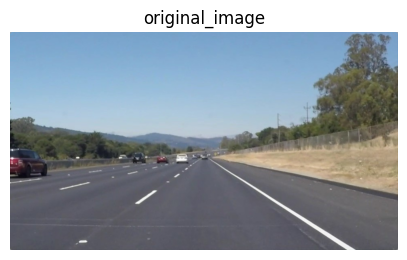

In [13]:
road_image = cv2.imread('road.png')
show('original_image', road_image)

Explain your logic here

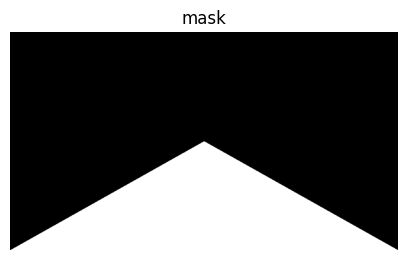

In [14]:
H, W, _ = road_image.shape

# Generate mask for ROI (Region of Interest)
mask = np.zeros((H, W))
for i in range(H):
    for j in range(W):
        if  i > -j*(H / W) + H and i > j*(H / W):
            mask[i, j] = 1

show('mask', mask)



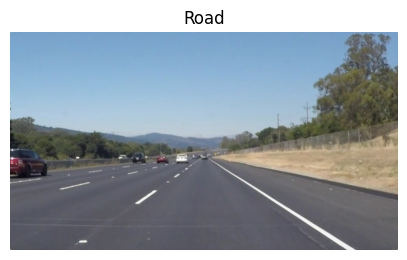

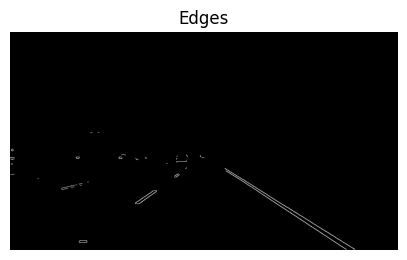

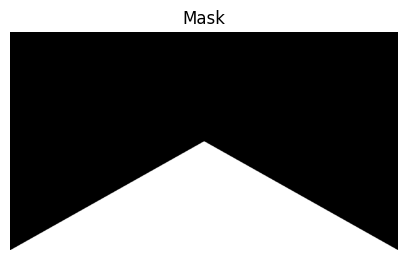

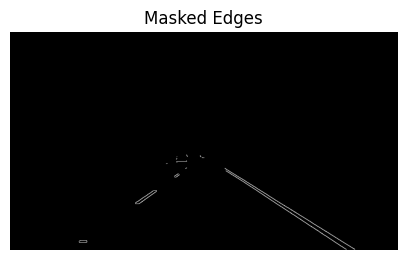

In [16]:
def Canny(image, low_threshold, high_threshold):
    # convert image to grayscale, if it is not gray
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(image, (5, 5), 1.4)

    # Calculate Sobel derivatives
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)

    # find gradient magnitudes from sobelx and sobely
    magnitude = np.sqrt(sobelx**2 + sobely**2)

    # find gradient directions, use np.arctan2(x1, x2) - will give you arc tangent of x1/x2
    direction = np.arctan2(sobely, sobelx)

    # Normalize magnitude to 0-255 range
    if np.max(magnitude) > 0:
        magnitude_normalized = (magnitude / np.max(magnitude)) * 255
    else:
        magnitude_normalized = magnitude
    magnitude_normalized = magnitude_normalized.astype(np.uint8)

    # non maximum suppression
    suppressed = np.zeros_like(magnitude_normalized, dtype=np.uint8)
    angle = direction * 180.0 / np.pi
    angle[angle < 0] += 180

    height, width = magnitude_normalized.shape
    for i in range(1, height-1):
        for j in range(1, width-1):
            # Determine the neighbors to check based on gradient direction
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                neighbors = [magnitude_normalized[i, j-1], magnitude_normalized[i, j+1]]
            elif 22.5 <= angle[i, j] < 67.5:
                neighbors = [magnitude_normalized[i-1, j-1], magnitude_normalized[i+1, j+1]]
            elif 67.5 <= angle[i, j] < 112.5:
                neighbors = [magnitude_normalized[i-1, j], magnitude_normalized[i+1, j]]
            elif 112.5 <= angle[i, j] < 157.5:
                neighbors = [magnitude_normalized[i-1, j+1], magnitude_normalized[i+1, j-1]]

            # Keep pixel if it's a local maximum
            if magnitude_normalized[i, j] >= max(neighbors):
                suppressed[i, j] = magnitude_normalized[i, j]

    # double threshold
    if low_threshold > 200 or high_threshold > 250:
        low_threshold = 30
        high_threshold = 90

    strong_edges = (suppressed > high_threshold)
    weak_edges = (suppressed >= low_threshold) & (suppressed <= high_threshold)

    # disambiguation area trace
    # Edge tracking by hysteresis
    edges = strong_edges.astype(np.uint8) * 255
    height, width = edges.shape

    # Perform edge linking
    for i in range(1, height-1):
        for j in range(1, width-1):
            if weak_edges[i, j]:
                # Check if any of the 8 neighbors is a strong edge
                if (strong_edges[i-1:i+2, j-1:j+2].any()):
                    edges[i, j] = 255

    return edges

road_image = cv2.imread("road.png")
edges = Canny(road_image, 50, 150)
masked_edges = mask * edges

show("Road", road_image)
show("Edges", edges)
show("Mask", mask)
show("Masked Edges", masked_edges)